In [4]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from utils import Dataset
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
#from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

import pandas as pd
import numpy as np
from pickle import load
from tqdm import tqdm
from itertools import product

from utils import one_vs_all, plot_roc, get_prob_and_pred

from sklearn.model_selection import GridSearchCV
from utils import plot_roc

In [5]:
# read the csv files / datasets into a pandas dataframe
train_data = pd.read_csv("pump_train.csv")
test_data = pd.read_csv("pump_test.csv")

In [6]:
train_data.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,12237,30.0,2013-01-23,Government Of Tanzania,107,District Council,39.360880,-10.295705,Zahanati Membe,0,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe multiple,communal standpipe,functional
1,24566,0.0,2013-02-07,Private Individual,0,Edward,32.644074,-3.859265,Kwa Mama Wini,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,functional
2,20536,0.0,2011-07-15,Sawaka,0,DWE,30.999792,-1.721771,Kwasimon,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,30633,200.0,2011-03-25,Government Of Tanzania,2142,Commu,34.060324,-9.335288,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
4,2993,0.0,2011-02-17,African Muslim Agency,290,District Council,38.862874,-7.165410,Msikitini,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
5,41668,0.0,2013-02-15,Nyitamboka,1229,Nyitamboka,34.349079,-1.630274,Nyitamboka Kitanyita,0,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
6,61839,0.0,2013-02-09,Rwssp,0,DWE,32.586745,-3.815508,Idete,0,...,milky,milky,dry,dry,shallow well,shallow well,groundwater,other,other,non functional
7,62441,0.0,2011-02-21,Government Of Tanzania,75,Centr,39.010886,-7.615327,Nyambili Primary School 2,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
8,53492,0.0,2012-10-18,Member Of Perliament Ahmed Ali,0,Member of Perliament Ahmed Ali,33.165581,-3.796312,Kwa Hima Ganaye,0,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
9,54314,0.0,2011-08-01,The Desk And Chair Foundat,0,The desk and chair foundat,33.326639,-3.027799,Nguruko,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50490 entries, 0 to 50489
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     50490 non-null  int64  
 1   amount_tsh             50490 non-null  float64
 2   date_recorded          50490 non-null  object 
 3   funder                 47396 non-null  object 
 4   gps_height             50490 non-null  int64  
 5   installer              47380 non-null  object 
 6   longitude              50490 non-null  float64
 7   latitude               50490 non-null  float64
 8   wpt_name               50490 non-null  object 
 9   num_private            50490 non-null  int64  
 10  basin                  50490 non-null  object 
 11  subvillage             50175 non-null  object 
 12  region                 50490 non-null  object 
 13  region_code            50490 non-null  int64  
 14  district_code          50490 non-null  int64  
 15  lg

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,50490.0,37113.857695,21447.241039,0.000000,18517.250000,37027.500000,55636.750000,7.424700e+04
amount_tsh,50490.0,319.158123,2987.517185,0.000000,0.000000,0.000000,20.000000,3.500000e+05
gps_height,50490.0,669.714280,693.123330,-90.000000,0.000000,371.000000,1322.000000,2.770000e+03
longitude,50490.0,34.078591,6.553382,0.000000,33.084409,34.906548,37.178899,4.034519e+01
latitude,50490.0,-5.708336,2.943806,-11.648378,-8.541643,-5.019807,-3.327550,-2.000000e-08
num_private,50490.0,0.459497,10.413455,0.000000,0.000000,0.000000,0.000000,1.402000e+03
region_code,50490.0,15.280511,17.550035,1.000000,5.000000,12.000000,17.000000,9.900000e+01
district_code,50490.0,5.641731,9.668596,0.000000,2.000000,3.000000,5.000000,8.000000e+01
population,50490.0,180.913389,479.854870,0.000000,0.000000,25.000000,215.750000,3.050000e+04
construction_year,50490.0,1301.724520,951.258506,0.000000,0.000000,1986.000000,2004.000000,2.013000e+03


In [9]:
# checking how many different values are there in each column
train_data.nunique()

id                       50490
amount_tsh                  94
date_recorded              348
funder                    1734
gps_height                2409
installer                 1964
longitude                48914
latitude                 48916
wpt_name                 32390
num_private                 62
basin                        9
subvillage               17774
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2085
population                 989
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2583
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [10]:
train_data.shape

(50490, 41)

In [11]:
# Datensatz nach fehlenden Werten untersuchen
train_data.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3094
gps_height                   0
installer                 3110
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 315
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2846
recorded_by                  0
scheme_management         3269
scheme_name              23942
permit                    2591
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [12]:
number= sum(train_data[train_data.status_group == 'functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number) + " Frauds mit einem Betrag über 1000.")

Es gibt im Datensatz insgesamt 13663 Frauds mit einem Betrag über 1000.


In [13]:
number1= sum(train_data[train_data.status_group == 'non functional'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number) + " Frauds mit einem Betrag über 1000.")

Es gibt im Datensatz insgesamt 13663 Frauds mit einem Betrag über 1000.


In [14]:
number2= sum(train_data[train_data.status_group == 'functional needs repair'].value_counts())
print("Es gibt im Datensatz insgesamt " + str(number) + " Frauds mit einem Betrag über 1000.")

Es gibt im Datensatz insgesamt 13663 Frauds mit einem Betrag über 1000.


In [15]:
sum = number + number1 + number2
print(sum)

23650


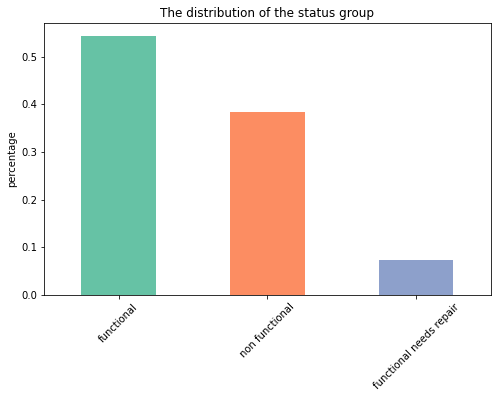

In [16]:
# defining colors for the plots
my_cmap = plt.get_cmap("Set2")
# making the plot
fig = plt.figure(figsize=(8,5))  
train_data.status_group.value_counts(normalize = "true").plot(kind="bar", title="The distribution of the status group", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

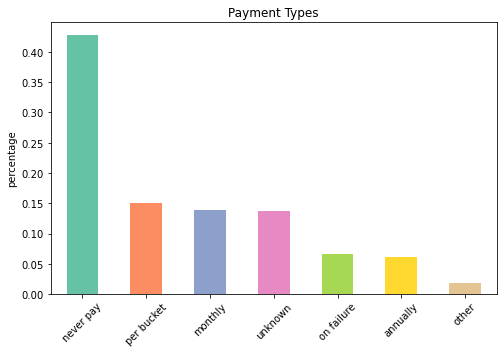

In [17]:
fig = plt.figure(figsize=(8,5))  
train_data.payment_type.value_counts(normalize = "true").plot(kind="bar", title="Payment Types", ylabel="percentage", color=my_cmap.colors)
plt.xticks(rotation=45);

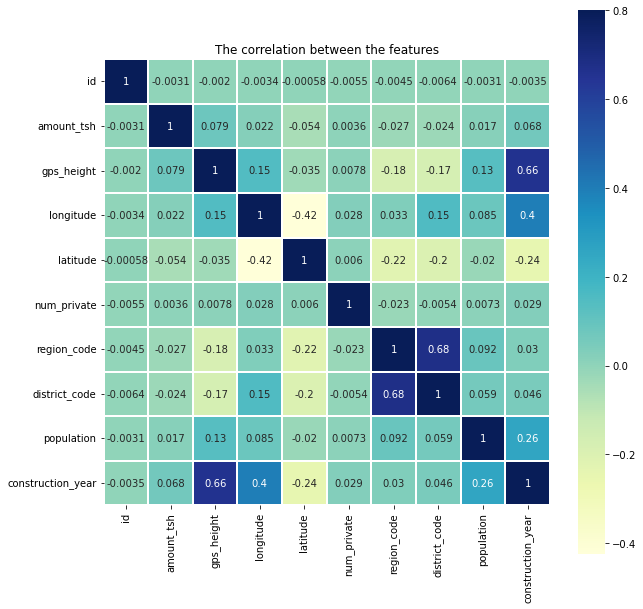

In [18]:
corr=train_data.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('The correlation between the features');

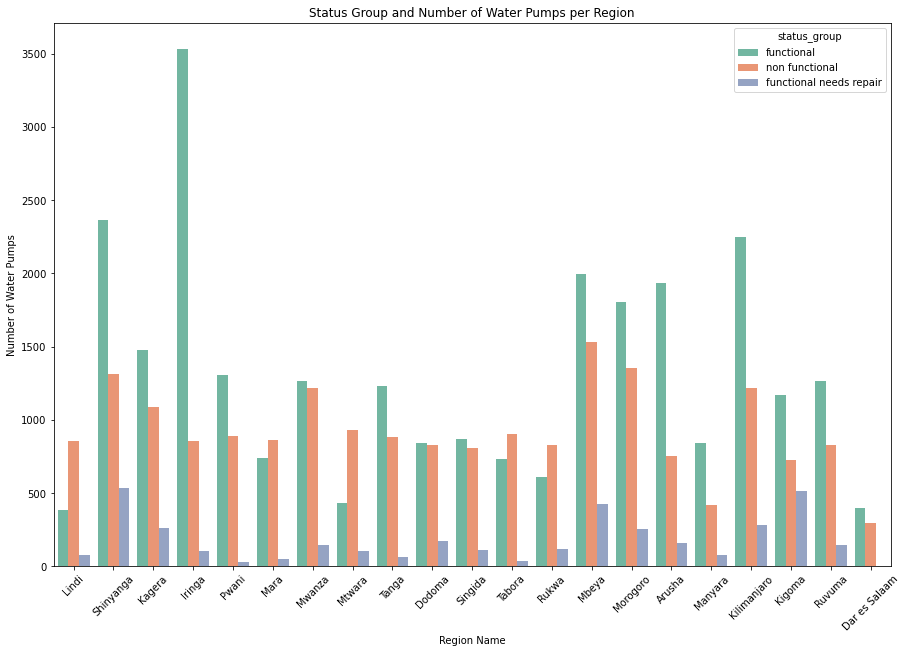

In [19]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='region', hue='status_group', palette="Set2")
plot.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Status Group and Number of Water Pumps per Region')
plt.xticks(rotation=45);
# Quelle: https://github.com/dustiny5/Predictive_Modeling/blob/master/Water_Pump_Best%20-%20Final.ipynb

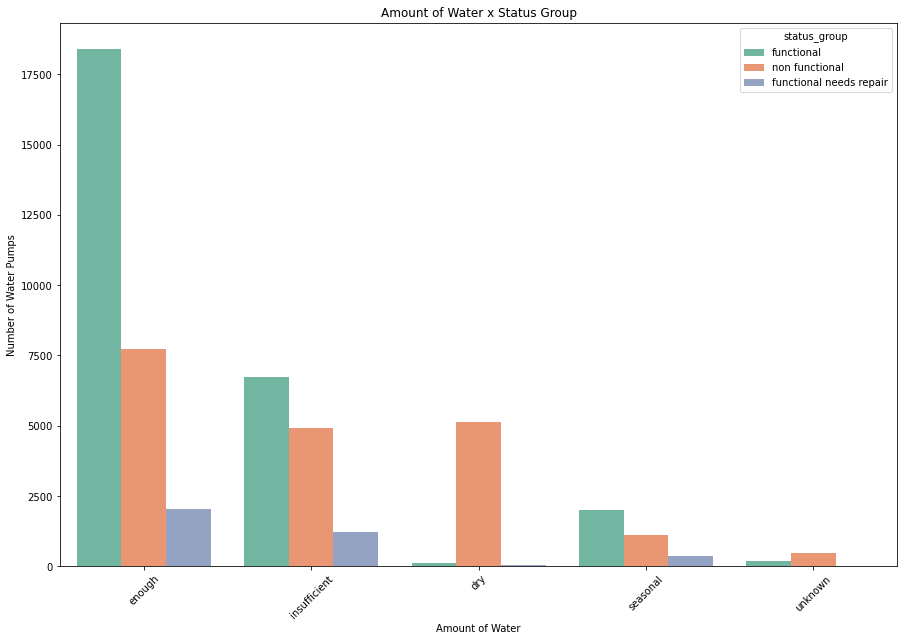

In [20]:
fig = plt.figure(figsize=(15,10))  
plot = sns.countplot(data=train_data, x='quantity', hue='status_group', palette="Set2")
plot.set(xlabel='Amount of Water', ylabel='Number of Water Pumps', title='Amount of Water x Status Group')
plt.xticks(rotation=45);
# Quelle: https://github.com/dustiny5/Predictive_Modeling/blob/master/Water_Pump_Best%20-%20Final.ipynb

1.29% of the pumps in the dataset are private


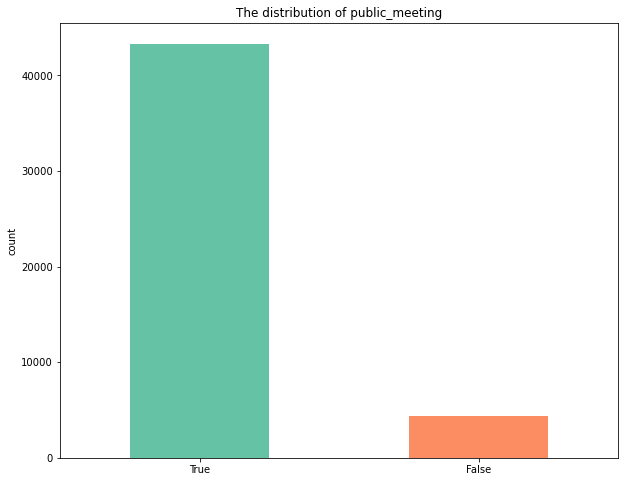

In [21]:
fig = plt.figure(figsize=(10,8))  
train_data.public_meeting.value_counts().plot(kind="bar", title="The distribution of public_meeting", ylabel="count", color=my_cmap.colors)
plt.xticks(rotation=0);
print(f"{len(train_data.num_private[train_data.num_private!=0])/len(train_data):.2%} of the pumps in the dataset are private");

In [22]:
# function for plotting pie charts for each given category
def plot_multiple_pie_by_category(df, category, n_max=None, n_cols=3):
    if n_max is None:
        categories = df[category].unique()
    else:
        categories = df[category].value_counts().index.tolist()[:n_max]
    
    n_rows = len(categories)
    fig = make_subplots(rows=len(categories)//n_cols, cols=n_cols, specs=[[{"type": "pie"}]*n_cols]*(len(categories)//n_cols))
    for i, label in enumerate(categories):
        df_label = df[df[category] == label]
        fig.add_trace(go.Pie(labels=df_label["status_group"].unique(),
        values=df_label["status_group"].value_counts(), 
        name=label, title=f"{label}: {len(df_label)} pumps"), row=i//n_cols+1, col=i%n_cols+1)
    fig.update_layout(height=max(900, n_rows*100), width=1800)
    fig.show()

In [23]:
plot_multiple_pie_by_category(train_data, "funder", n_max=21)

In [24]:
px.box(train_data, x="population", y="status_group")

In [25]:
fig = px.scatter_geo(train_data.sample(1_000), lat="latitude", lon="longitude", color="status_group",  scope="africa", opacity=0.7)
fig.show()

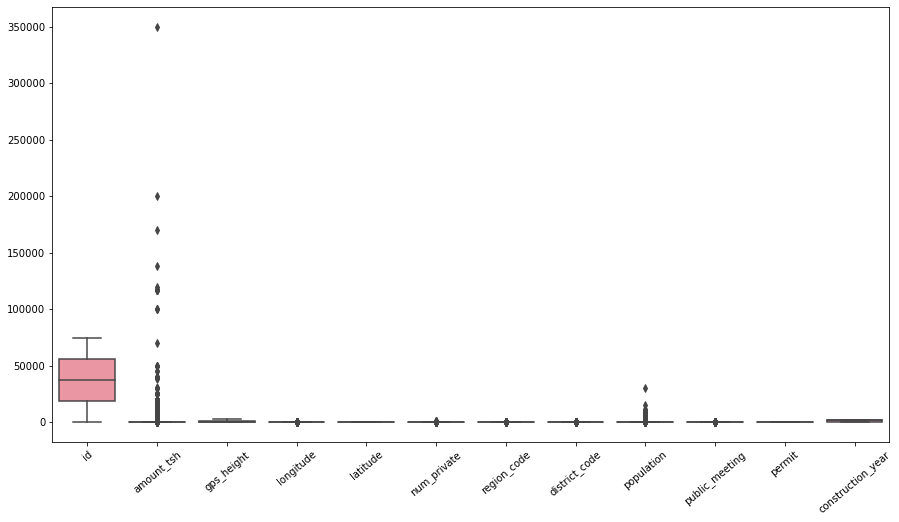

In [26]:
plt.figure(figsize = (15,8))
ax = sns.boxplot(data=train_data)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40);

In [27]:
train_data.isnull().sum().sort_values(ascending=False)

scheme_name              23942
scheme_management         3269
installer                 3110
funder                    3094
public_meeting            2846
permit                    2591
subvillage                 315
payment                      0
waterpoint_type_group        0
extraction_type_group        0
extraction_type_class        0
waterpoint_type              0
management                   0
management_group             0
source_class                 0
source_type                  0
water_quality                0
quality_group                0
extraction_type              0
quantity                     0
quantity_group               0
source                       0
payment_type                 0
id                           0
construction_year            0
basin                        0
date_recorded                0
gps_height                   0
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
region  

=> um welche Datentypen es sich handelt => ersetzen mit mean oder median oder eventuell Random Forest, um Daten hervorzusagen\
=> Umgang mit Ausreißern

In [28]:
# fehlende Werte im Test-Datensatz
test_data.isnull().sum().sort_values(ascending=False)

scheme_name              4224
scheme_management         608
installer                 545
funder                    541
public_meeting            488
permit                    465
subvillage                 56
payment                     0
waterpoint_type_group       0
extraction_type_group       0
extraction_type_class       0
waterpoint_type             0
management                  0
management_group            0
source_class                0
source_type                 0
water_quality               0
quality_group               0
extraction_type             0
quantity                    0
quantity_group              0
source                      0
payment_type                0
id                          0
construction_year           0
basin                       0
date_recorded               0
gps_height                  0
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
region                      0
amount_tsh

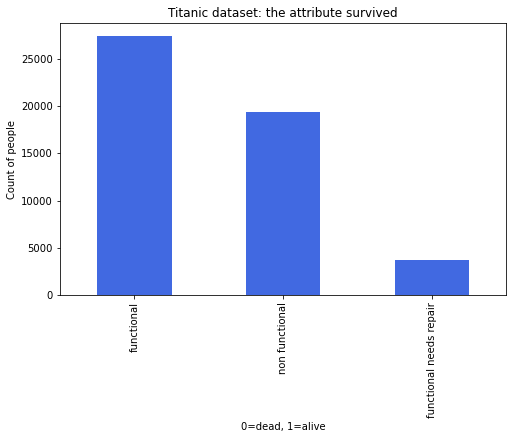

In [29]:
fig = plt.figure(figsize=(8,5))      
train_data.status_group.value_counts().plot(kind="bar", color="royalblue", title="Titanic dataset: the attribute survived", xlabel="0=dead, 1=alive", ylabel="Count of people");

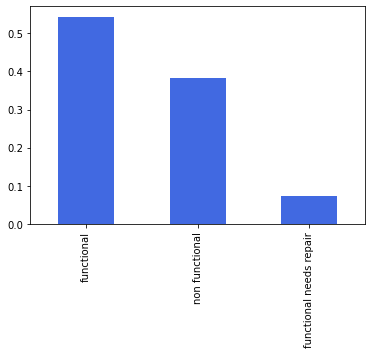

In [30]:
train_data.status_group.value_counts(normalize="True").plot(kind="bar", color="royalblue");

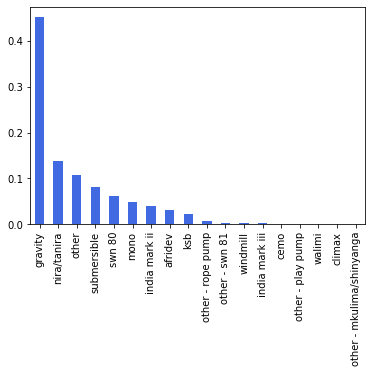

In [31]:
train_data.extraction_type.value_counts(normalize="True").plot(kind="bar", color="royalblue");

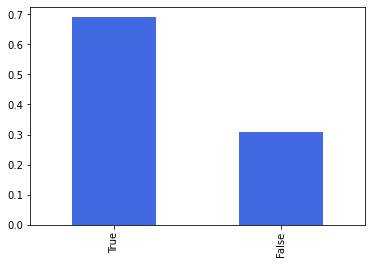

In [32]:
train_data.permit.value_counts(normalize="True").plot(kind="bar", color="royalblue");

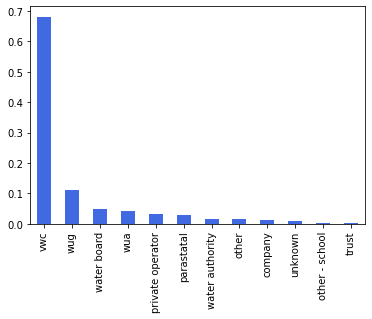

In [33]:
train_data.management.value_counts(normalize="True").plot(kind="bar", color="royalblue");

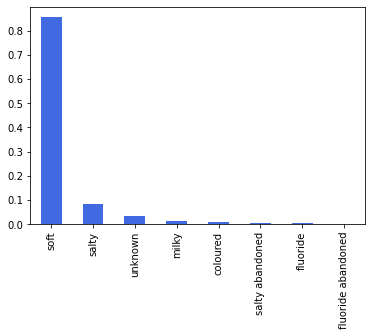

In [34]:
train_data.water_quality.value_counts(normalize="True").plot(kind="bar", color="royalblue");

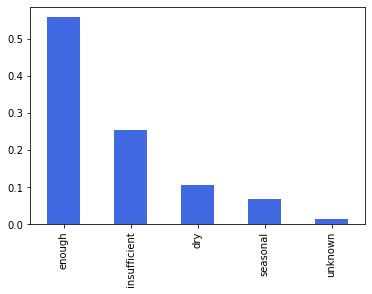

In [35]:
train_data.quantity.value_counts(normalize="True").plot(kind="bar", color="royalblue");

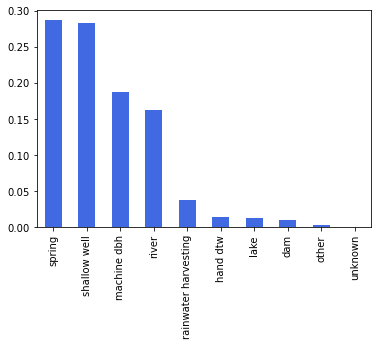

In [36]:
train_data.source.value_counts(normalize="True").plot(kind="bar", color="royalblue");

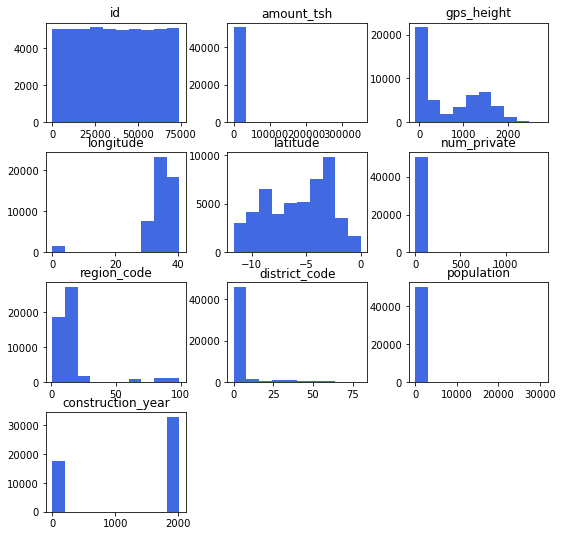

In [37]:
train_data.hist(bins=10,figsize=(9,9),grid=False,color="royalblue");

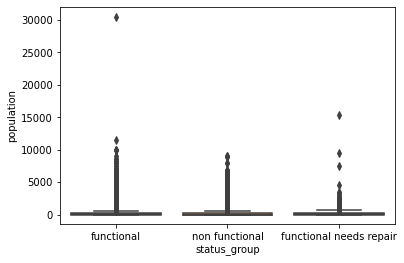

In [38]:
my_palette=["#3274a1", "#e1812c"]
ax = sns.boxplot(x="status_group", y="population", data=train_data, palette=my_palette)

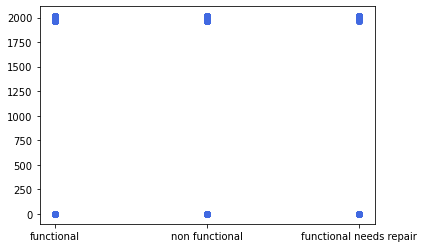

In [39]:
plt.scatter(train_data['status_group'] ,train_data['construction_year'], alpha = 0.1, color="royalblue")

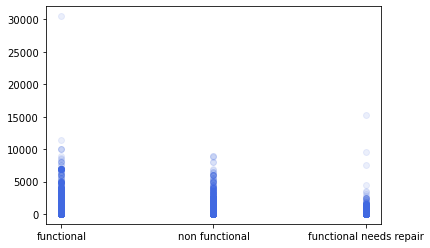

In [40]:
plt.scatter(train_data['status_group'] ,train_data['population'], alpha = 0.1, color="royalblue")

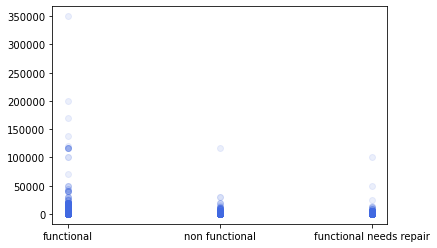

In [41]:
plt.scatter(train_data['status_group'] ,train_data['amount_tsh'], alpha = 0.1, color="royalblue")

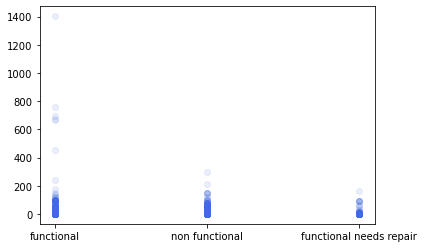

In [42]:
plt.scatter(train_data['status_group'] ,train_data['num_private'], alpha = 0.1, color="royalblue")

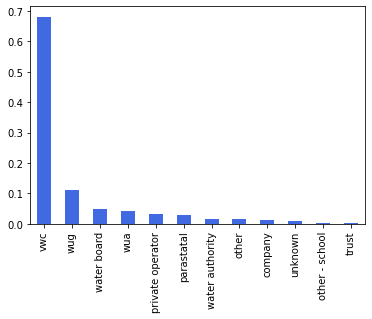

In [43]:
train_data.management.value_counts(normalize="True").plot(kind="bar", color="royalblue");

In [44]:
nfunctional = train_data[train_data['status_group'] == 'non functional'] 
repairable = train_data[train_data['status_group'] == 'functional needs repair'] 
functional = train_data[train_data['status_group'] == 'functional'] 

<AxesSubplot:>

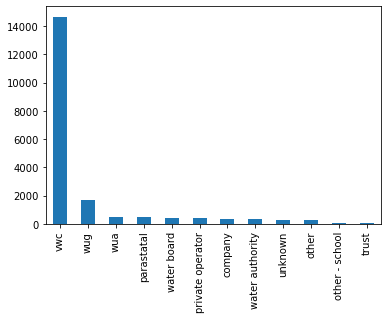

In [45]:
nfunctional.management.value_counts().plot(kind="bar")

<AxesSubplot:>

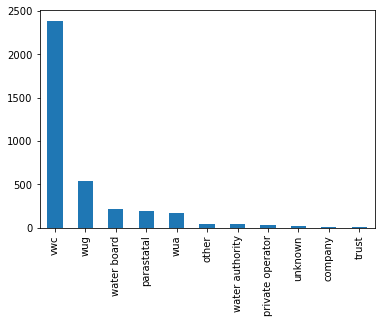

In [46]:
repairable.management.value_counts().plot(kind="bar")


<AxesSubplot:>

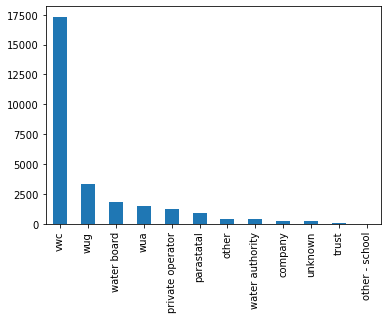

In [47]:
functional.management.value_counts().plot(kind="bar")

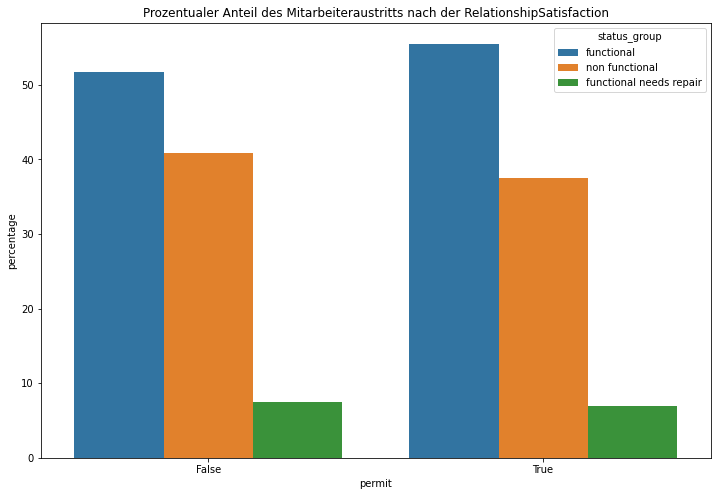

In [48]:
plt.figure(figsize=(12,8))

attrition_counts = (train_data.groupby(['permit'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('permit'))
plt.title('Prozentualer Anteil des Mitarbeiteraustritts nach der RelationshipSatisfaction')
sns.barplot(x="permit", y="percentage", hue="status_group", data=attrition_counts);

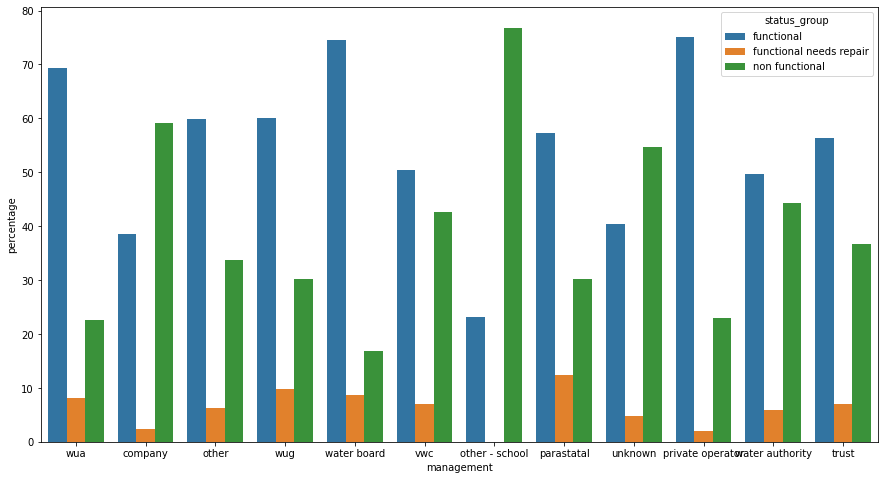

In [49]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['management'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="management", y="percentage", hue="status_group", data=attrition_counts);

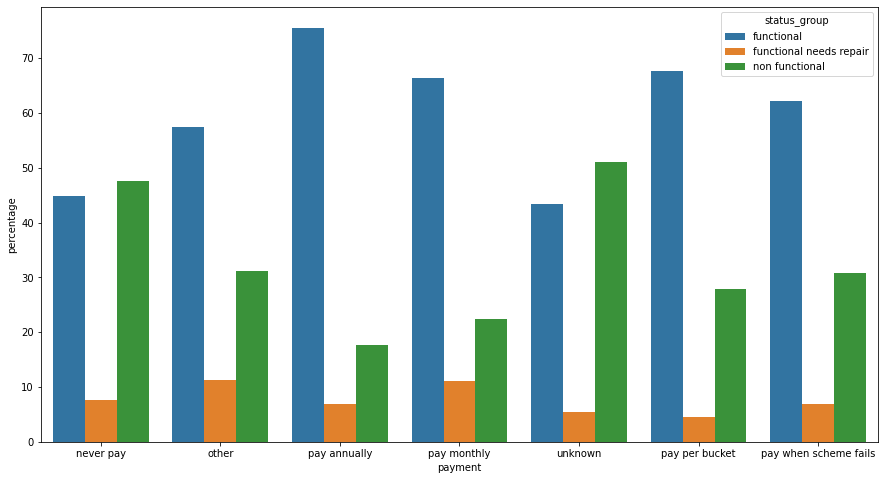

In [53]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['payment'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="payment", y="percentage", hue="status_group", data=attrition_counts);

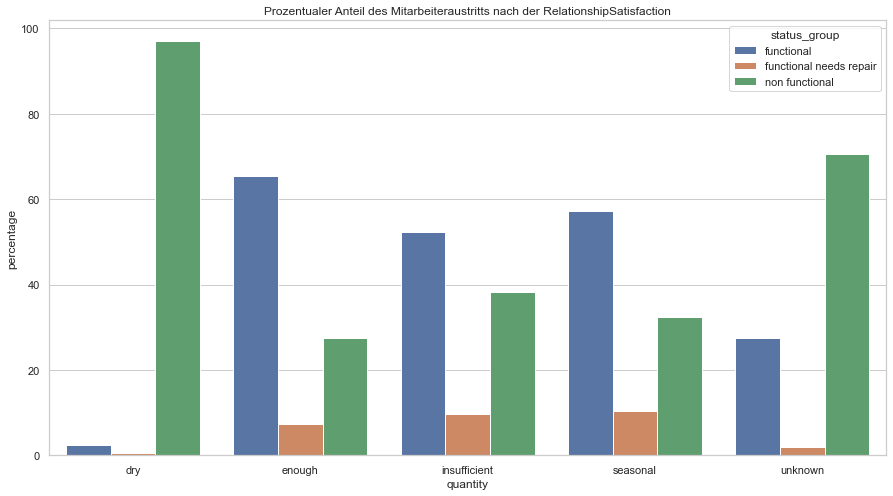

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['quantity'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="quantity", y="percentage", hue="status_group", data=attrition_counts);

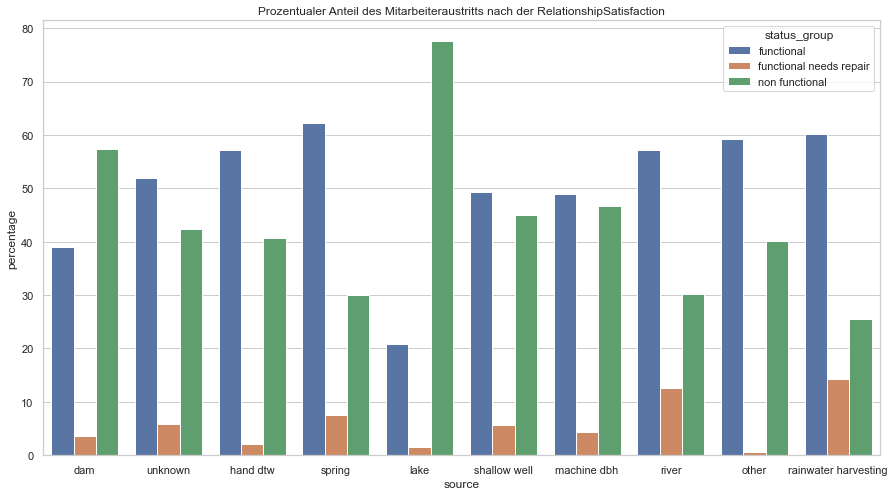

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['source'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="source", y="percentage", hue="status_group", data=attrition_counts);

=> source to be eliminated

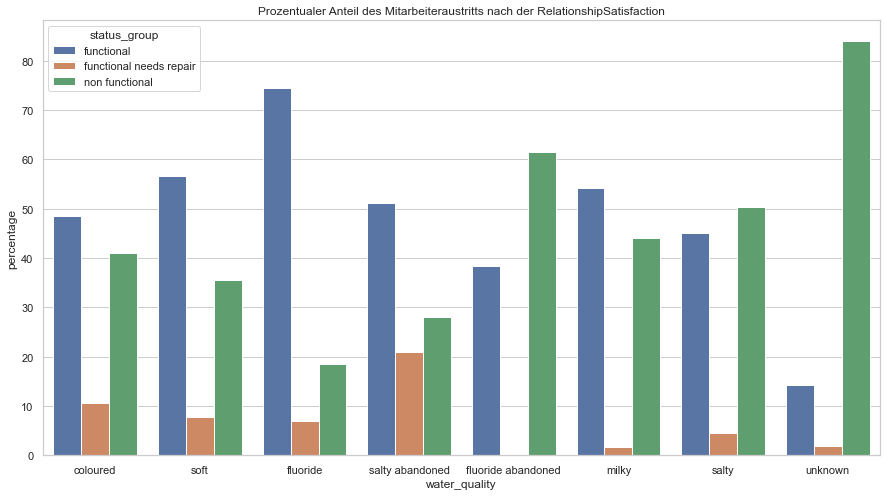

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['water_quality'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="water_quality", y="percentage", hue="status_group", data=attrition_counts);

=> eliminate water_quality

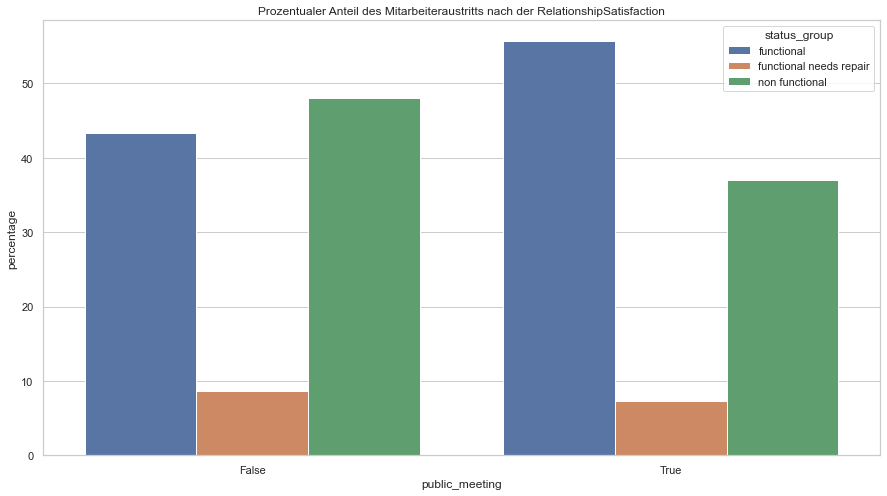

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['public_meeting'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
sns.barplot(x="public_meeting", y="percentage", hue="status_group", data=attrition_counts);

=> public_meeting might have influence on the status_group

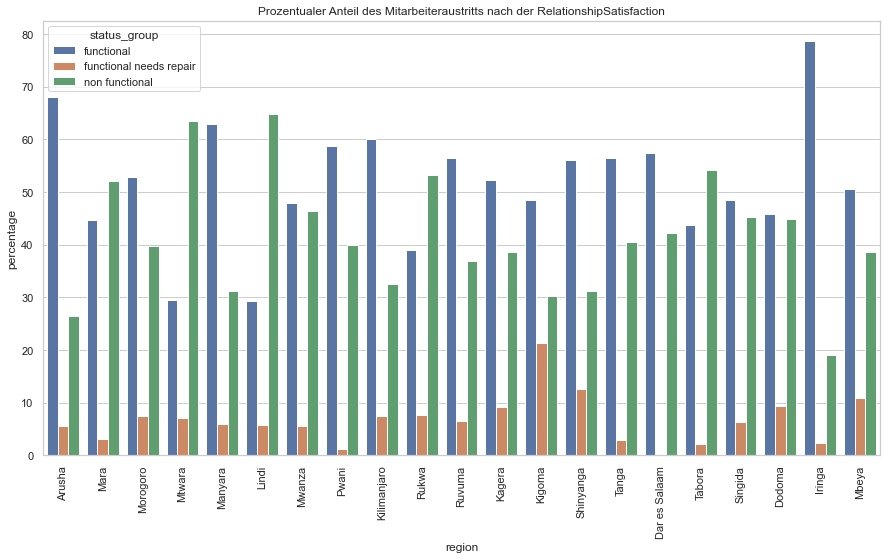

In [ ]:
plt.figure(figsize=(15,8))

attrition_counts = (train_data.groupby(['region'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('status_group'))
plt.xticks(rotation=90)
sns.barplot(x="region", y="percentage", hue="status_group", data=attrition_counts);

=> region obviously doesnt have any influence

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

Python version: 3.9.7
numpy version: 1.20.3
pandas version: 1.3.4
scikit-learn version: 0.24.2


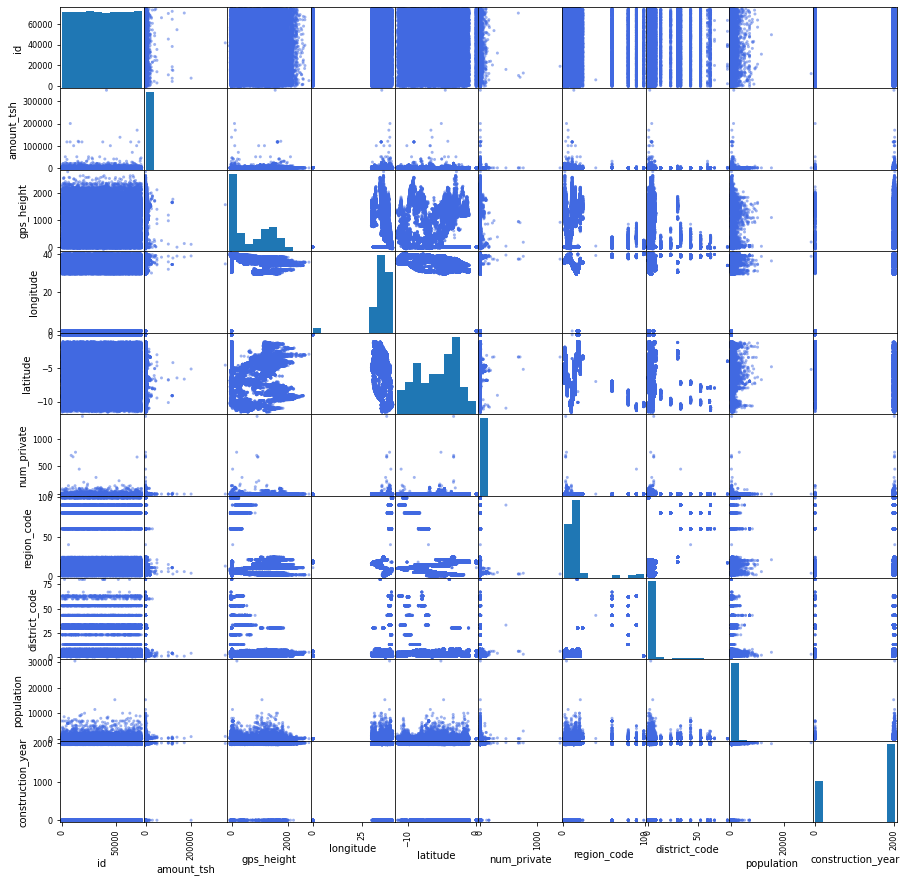

In [51]:
pd.plotting.scatter_matrix(train_data, color="royalblue", figsize=(15,15));

In [57]:
print("Train data rows, columns:",train_data.shape)
print("Test data rows, columns:", test_data.shape)

Train data rows, columns: (50490, 41)
Test data rows, columns: (8910, 41)


In [66]:
print(len(train_data.funder.value_counts(dropna=False)))

1735


In [74]:
counts=train_data.funder.value_counts(dropna=False)
pd.set_option("display.max_rows", None)
counts

Government Of Tanzania            7697
NaN                               3094
Danida                            2627
Hesawa                            1868
Rwssp                             1160
World Bank                        1130
Kkkt                              1115
World Vision                      1071
Unicef                             912
Tasaf                              764
Private Individual                 730
District Council                   718
Dhv                                706
Dwsp                               677
0                                  675
Norad                              655
Germany Republi                    523
Tcrs                               523
Ministry Of Water                  496
Water                              481
Dwe                                416
Netherlands                        398
Adb                                385
Hifab                              379
Lga                                367
Amref                    

In [75]:
train_data.construction_year.value_counts(dropna=False)

0       17575
2010     2243
2008     2211
2009     2167
2000     1759
2007     1323
2006     1260
2003     1092
2011     1065
2004      952
2012      934
2002      924
1978      901
2005      873
1995      861
1999      828
1990      819
1998      814
1985      811
1996      687
1984      673
1980      664
1982      656
1994      619
1972      616
1974      572
1997      548
1992      545
1993      520
2001      460
1988      431
1983      406
1975      385
1986      365
1970      355
1976      353
1991      284
1989      269
1987      257
1981      200
1977      168
1979      162
1973      156
2013      145
1971      126
1960       87
1963       75
1967       73
1968       64
1969       46
1964       34
1962       28
1961       18
1966       16
1965       15
Name: construction_year, dtype: int64

### Droppen der unnötigen Zellen

In [ ]:
dropped_features=['date_recorded',
                         'funder',
                      'installer',
                      'longitude',
                       'latitude',
                       'wpt_name',
                    'num_private',
                          'basin',
                     'subvillage',
                         'region',
                            'lga',
                           'ward',
                    'recorded_by',
                    'scheme_name',
          'waterpoint_type_group',                  
          'extraction_type_group',
          'extraction_type_class', 
                              'id']

train_data.drop(columns=dropped_features, inplace=True )
test_data.drop(columns=dropped_features, inplace=True )

umwandeln von permit und public_meeting von boolean nach int

In [ ]:
train_data.permit = train_data.permit.astype(bool).astype(int)
train_data.public_meeting = train_data.public_meeting.astype(bool).astype(int)

In [ ]:
# umwandeln der Strings von status_group in Encoding
# process labels
label_dict_status_group = {'functional':0,
                   'non functional': 1,
                   'functional needs repair': 2}
train_labels.status_group = train_labels.status_group.replace(label_dict_status_group)

In [ ]:
prep = train_data[['survived','sex','age','pclass', 'fare', 'sibsp','embarked']]
test_prep = test_data[['sex','age','pclass', 'fare', 'sibsp','embarked']]

In [ ]:
from sklearn.model_selection import train_test_split

predictors = prep.drop('survived', axis=1)
target = prep["survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.2, random_state = 0)

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)

In [ ]:
y_pred = decisiontree.predict(x_val)

Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)

Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(n_estimators=300, max_depth=3)
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)

Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)

SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)

Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)

## Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score

#Cross Validation mittels Accuracy für den Decision Tree
accuracy_dt = cross_val_score(decisiontree, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_dt = accuracy_dt.mean()

#Cross Validation mittels Accuracy für Gaussian Naive Bayes
accuracy_gaussian = cross_val_score(gaussian, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_gaussian = accuracy_gaussian.mean()

#Cross Validation mittels Accuracy für Logistic Regression
accuracy_logreg = cross_val_score(logreg, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_logreg = accuracy_logreg.mean()

#Cross Validation mittels Accuracy für Perceptron
accuracy_perceptron = cross_val_score(perceptron, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_perceptron = accuracy_perceptron.mean()

#Cross Validation mittels Accuracy für Random Forest
accuracy_rf = cross_val_score(randomforest, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_rf = accuracy_rf.mean()

#Cross Validation mittels Accuracy für KNN
accuracy_knn = cross_val_score(knn, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_knn = accuracy_knn.mean()

#Cross Validation mittels Accuracy für Stochastic Gradient Descent
accuracy_sgd = cross_val_score(sgd, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_sgd = accuracy_sgd.mean()

#Cross Validation mittels Accuracy für Super Vector Machine
accuracy_svc = cross_val_score(svc, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_svc = accuracy_svc.mean()

#Cross Validation mittels Accuracy für Gradient Boosting Classifier
accuracy_gbk = cross_val_score(gbk, x_train, y_train, scoring='accuracy', cv = 10)
cross_val_mean_gbk = accuracy_gbk.mean()

#Tabellarische Darstellung der Werte
models = pd.DataFrame({
    'Modell': ['Entscheidungsbaum', 'Gaussian Naive Bayes','Logistic Regression', 'Perceptron' ,'Random Forest', 'KNN', 'Stochastic Gradient Descent' , 'Support Vector Machines', 'Gradient Boosting Classifier'],
    'Faltung 1': [accuracy_dt[0], accuracy_gaussian[0], accuracy_logreg[0], accuracy_perceptron[0] ,accuracy_rf[0], accuracy_knn[0], accuracy_sgd[0] ,accuracy_svc[0], accuracy_gbk[0]],
    'Faltung 2': [accuracy_dt[1], accuracy_gaussian[1], accuracy_logreg[1], accuracy_perceptron[1] ,accuracy_rf[1], accuracy_knn[1], accuracy_sgd[1] ,accuracy_svc[1], accuracy_gbk[1]],
    'Faltung 3': [accuracy_dt[2], accuracy_gaussian[2], accuracy_logreg[2], accuracy_perceptron[2] ,accuracy_rf[2], accuracy_knn[2], accuracy_sgd[2] ,accuracy_svc[2], accuracy_gbk[2]],
    'Faltung 4': [accuracy_dt[3], accuracy_gaussian[3], accuracy_logreg[3], accuracy_perceptron[3] ,accuracy_rf[3], accuracy_knn[3], accuracy_sgd[3] ,accuracy_svc[3], accuracy_gbk[3]],
    'Faltung 5': [accuracy_dt[4], accuracy_gaussian[4], accuracy_logreg[4], accuracy_perceptron[4] ,accuracy_rf[4], accuracy_knn[4], accuracy_sgd[4] ,accuracy_svc[4], accuracy_gbk[4]],
    'Faltung 6': [accuracy_dt[5], accuracy_gaussian[5], accuracy_logreg[5], accuracy_perceptron[5] ,accuracy_rf[5], accuracy_knn[5], accuracy_sgd[5] ,accuracy_svc[5], accuracy_gbk[5]],
    'Faltung 7': [accuracy_dt[6], accuracy_gaussian[6], accuracy_logreg[6], accuracy_perceptron[6] ,accuracy_rf[6], accuracy_knn[6], accuracy_sgd[6] ,accuracy_svc[6], accuracy_gbk[6]],
    'Faltung 8': [accuracy_dt[7], accuracy_gaussian[7], accuracy_logreg[7], accuracy_perceptron[7] ,accuracy_rf[7], accuracy_knn[7], accuracy_sgd[7] ,accuracy_svc[7], accuracy_gbk[7]],
    'Faltung 9': [accuracy_dt[8], accuracy_gaussian[8], accuracy_logreg[8], accuracy_perceptron[8] ,accuracy_rf[8], accuracy_knn[8], accuracy_sgd[8] ,accuracy_svc[8], accuracy_gbk[8]],
    'Faltung 10': [accuracy_dt[9], accuracy_gaussian[9], accuracy_logreg[9], accuracy_perceptron[9] ,accuracy_rf[9], accuracy_knn[9], accuracy_sgd[9] ,accuracy_svc[9], accuracy_gbk[9]],
    'Durchschnitt': [cross_val_mean_dt,cross_val_mean_gaussian,cross_val_mean_logreg,cross_val_mean_perceptron, cross_val_mean_rf, cross_val_mean_knn, cross_val_mean_sgd, cross_val_mean_svc, cross_val_mean_gbk]
})
models.sort_values(by='Durchschnitt', ascending=False)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_train_pred_dt = cross_val_predict(decisiontree, x_train, y_train, cv=3)

from sklearn.metrics import confusion_matrix
conm_dt = confusion_matrix(y_train, y_train_pred_dt)

#Berechnung der Werte für den Entscheidungsbaum
from sklearn.metrics import precision_score, recall_score
prec_dt = precision_score(y_train, y_train_pred_dt)
rec_dt = recall_score(y_train, y_train_pred_dt)

from sklearn.metrics import f1_score
f1_dt = f1_score(y_train, y_train_pred_dt)

#Berechnung der Werte für Gaussian Naive Bayes
y_train_pred_gaussian = cross_val_predict(gaussian, x_train, y_train, cv=3)
conm_gaussian = confusion_matrix(y_train, y_train_pred_gaussian)
prec_gaussian = precision_score(y_train, y_train_pred_gaussian)
rec_gaussian = recall_score(y_train, y_train_pred_gaussian)
f1_gaussian = f1_score(y_train, y_train_pred_gaussian)

#Berechnung der Werte für Logistic Regression
y_train_pred_logreg = cross_val_predict(logreg, x_train, y_train, cv=3)
conm_logreg = confusion_matrix(y_train, y_train_pred_logreg)
prec_logreg = precision_score(y_train, y_train_pred_logreg)
rec_logreg = recall_score(y_train, y_train_pred_logreg)
f1_logreg = f1_score(y_train, y_train_pred_logreg)

#Berechnung der Werte für Perceptron
y_train_pred_perceptron = cross_val_predict(perceptron, x_train, y_train, cv=3)
conm_perceptron = confusion_matrix(y_train, y_train_pred_perceptron)
prec_perceptron = precision_score(y_train, y_train_pred_perceptron)
rec_perceptron = recall_score(y_train, y_train_pred_perceptron)
f1_perceptron = f1_score(y_train, y_train_pred_perceptron)

#Berechnung der Werte für Random Forest
y_train_pred_rf = cross_val_predict(randomforest, x_train, y_train, cv=3)
conm_rf = confusion_matrix(y_train, y_train_pred_rf)
prec_rf = precision_score(y_train, y_train_pred_rf)
rec_rf = recall_score(y_train, y_train_pred_rf)
f1_rf = f1_score(y_train, y_train_pred_rf)

#Berechnung der Werte für KNN
y_train_pred_knn = cross_val_predict(knn, x_train, y_train, cv=3)
conm_knn = confusion_matrix(y_train, y_train_pred_knn)
prec_knn = precision_score(y_train, y_train_pred_knn)
rec_knn = recall_score(y_train, y_train_pred_knn)
f1_knn = f1_score(y_train, y_train_pred_knn)

#Berechnung der Werte für Stochastic Gradient Descent
y_train_pred_sgd = cross_val_predict(sgd, x_train, y_train, cv=3)
conm_sgd = confusion_matrix(y_train, y_train_pred_sgd)
prec_sgd = precision_score(y_train, y_train_pred_sgd)
rec_sgd = recall_score(y_train, y_train_pred_sgd)
f1_sgd = f1_score(y_train, y_train_pred_sgd)

#Berechnung der Werte für SVC
y_train_pred_svc = cross_val_predict(svc, x_train, y_train, cv=3)
conm_svc = confusion_matrix(y_train, y_train_pred_svc)
prec_svc = precision_score(y_train, y_train_pred_svc)
rec_svc = recall_score(y_train, y_train_pred_svc)
f1_svc = f1_score(y_train, y_train_pred_svc)

#Berechnung der Werte für Gradient Boosting Classifier
y_train_pred_gbk = cross_val_predict(gbk, x_train, y_train, cv=3)
conm_gbk = confusion_matrix(y_train, y_train_pred_gbk)
prec_gbk = precision_score(y_train, y_train_pred_gbk)
rec_gbk = recall_score(y_train, y_train_pred_gbk)
f1_gbk = f1_score(y_train, y_train_pred_gbk)

#Darstellung der Werte
pd.DataFrame({
               'Modell': ['Entscheidungsbaum', 'Gaussian Naive Bayes','Logistic Regression', 'Perceptron' ,'Random Forest', 'KNN', 'Stochastic Gradient Descent' , 'Support Vector Machines', 'Gradient Boosting Classifier'],
               'TN': [conm_dt[0][0], conm_gaussian[0][0], conm_logreg[0][0], conm_perceptron[0][0], conm_rf[0][0], conm_knn[0][0], conm_sgd[0][0], conm_svc[0][0], conm_gbk[0][0]],
               'FP': [conm_dt[0][1], conm_gaussian[0][1], conm_logreg[0][1], conm_perceptron[0][1], conm_rf[0][1], conm_knn[0][1], conm_sgd[0][1], conm_svc[0][1], conm_gbk[0][1]],
               'FN': [conm_dt[1][0], conm_gaussian[1][0], conm_logreg[1][0], conm_perceptron[1][0], conm_rf[1][0], conm_knn[1][0], conm_sgd[1][0], conm_svc[1][0], conm_gbk[1][0]],
               'TP': [conm_dt[1][1], conm_gaussian[1][1], conm_logreg[1][1], conm_perceptron[1][1], conm_rf[1][1], conm_knn[1][1], conm_sgd[1][1], conm_svc[1][1], conm_gbk[1][1]],
               'Precision': [prec_dt, prec_gaussian, prec_logreg, prec_perceptron, prec_rf, prec_knn, prec_sgd, prec_svc, prec_gbk],
               'Recall': [rec_dt, rec_gaussian, rec_logreg, rec_perceptron, rec_rf, rec_knn, rec_sgd, rec_svc, rec_gbk],
               'f1': [f1_dt, f1_gaussian, f1_logreg, f1_perceptron, f1_rf, f1_knn, f1_sgd, f1_svc, f1_gbk]
})

## Deployment

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

pd.read_csv("submission.csv")